In [1]:
import pandas as pd
import numpy as np
import datetime
import talib
import matplotlib.pyplot as plt
from wmpy.conf.settings import product_info_df, trade_days_list
from wmpy.trader.utility import get_previous_date, load_bar, load_bar_period, get_commission, map_parallel, get_trading_days, get_main_contract, read_sql_bar, get_symbol_name, np_shift, update_main_contract, get_main_contract_from_json
from wmpy.app.cta_backtester.backtesting_bar import cal_all_pnl, cal_daily_pnl # 注意这里是backtesting_bar

In [2]:
#过滤掉非交易时间
def bar_filter(bar_df, contract=None):
    def is_trading_time(dt):
        condition = (
            (dt.time() >= datetime.time(9, 0) and dt.time() < datetime.time(11, 30))    # 上午
         or (dt.time() >= datetime.time(13, 0) and dt.time() < datetime.time(15, 0)))  # 下午
         #or (dt.time() >= datetime.time(21, 0) and dt.time() < datetime.time(23, 0)))   # 夜盘
        return condition
    bool_list = [is_trading_time(x) for x in bar_df.index]
    return bar_df.loc[bool_list].copy()

In [3]:
#查看期货品种
import qgrid
qgrid.show_grid(product_info_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
symbol = 'IF'
start_date = 20201001
end_date = 20201231
date_list = get_trading_days(start_date=start_date,end_date=end_date)
update_main_contract(symbol, date_list)
contract_dict = get_main_contract_from_json(symbol, date_list, rank=1)

In [5]:
data_df = load_bar(contract_dict[date_list[0]],date_list[0])
for i in range(1,len(contract_dict)):
    bar_df = load_bar(contract_dict[date_list[i]], date_list[i])
    data_df = data_df.append(bar_df)
data_df = bar_filter(data_df)    

In [6]:
class DataProcessing:
    def __init__(self, train):
        self.file = data_df['close_price'].copy()
        self.train = train
        self.i = int(self.train * len(self.file))
        self.train_set = self.file[0: self.i]
        self.test_set = self.file[self.i:]
        self.input_train = []
        self.output_train = []
        self.input_test = []
        self.output_test = []
        
    def gen_train(self, seq_len):
        """
        产生训练数据
        seq_len: 考察窗口长度
        return: X_train and Y_train
        """
        for i in range((len(self.train_set)//seq_len)*seq_len - seq_len - 1):
            x = np.array(self.train_set.iloc[i: i + seq_len])
            y = np.array([self.train_set.iloc[i + seq_len + 1]], np.float64)
            self.input_train.append(x)
            self.output_train.append(y)
        self.X_train = np.array(self.input_train)
        self.Y_train = np.array(self.output_train)

    def gen_test(self, seq_len):
        """
        产生测试数据
        seq_len: 考察窗口长度
        return: X_test and Y_test
        """
        for i in range((len(self.test_set)//seq_len)*seq_len - seq_len - 1):
            x = np.array(self.test_set.iloc[i: i + seq_len])
            y = np.array([self.test_set.iloc[i + seq_len + 1]], np.float64)
            self.input_test.append(x)
            self.output_test.append(y)
        self.X_test = np.array(self.input_test)
        self.Y_test = np.array(self.output_test)

In [7]:
# 确定最佳的考察窗口长度
from sklearn.linear_model import LinearRegression
window_grid = np.arange(1,120)
best_window = 0
temp_score = 0
for window in window_grid:
    process = DataProcessing(0.8)
    process.gen_test(window)
    process.gen_train(window)
    model = LinearRegression().fit(process.X_train,process.Y_train)
    if temp_score < model.score(process.X_test,process.Y_test):
        best_window = window
    temp_score = max(temp_score,model.score(process.X_test,process.Y_test))


In [8]:
best_window

6

In [9]:
# 计算最佳的线性回归参数
process = DataProcessing(0.8)
process.gen_test(best_window)
process.gen_train(best_window)
lr = LinearRegression().fit(process.X_train,process.Y_train)
b = lr.intercept_
w = lr.coef_

In [10]:
w

array([[-0.00749219,  0.01767106, -0.01522419, -0.00949246,  0.04231612,
         0.97126633]])

In [11]:
b

array([4.70118259])

In [12]:
def lr_strategy(bar_df, date, contract, parameter_dict=None):
    
    WINDOW = parameter_dict['WINDOW']
    BUY_THRESHOLD = parameter_dict['OPEN_THRESHOLD']
    SELL_THRESHOLD = parameter_dict['CLOSE_THRESHOLD']
    
        
    start_date = get_previous_date(date, 2)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    # 当预测的收益高于实际收益一定阈值时，平空做多；
    # 当预测的收益低于于实际收益一定阈值时，平多做空。
    def lr_pred(x):
        return np.dot(w,x)+b
    factor_ser = data_df['close_price'].rolling(WINDOW).apply(lr_pred) - data_df['close_price']
    
    score_ser = pd.Series(factor_ser, index=bar_df.index)

    BUY_OPEN_THRESHOLD =  BUY_THRESHOLD
    SELL_OPEN_THRESHOLD = SELL_THRESHOLD

    SELL_CLOSE_THRESHOLD = SELL_THRESHOLD
    BUY_CLOSE_THRESHOLD = BUY_THRESHOLD

    ## 根据信号确定仓位
    signal_ser = pd.Series(data=0, index=score_ser.index)

    ## 先确定开仓时点
    buy_open_bool = score_ser >= BUY_OPEN_THRESHOLD
    signal_ser[buy_open_bool] = 1

    sell_open_bool = score_ser <= SELL_OPEN_THRESHOLD
    signal_ser[sell_open_bool] = -1

    ## 再确定平仓时点
    buy_close_bool = score_ser <= SELL_CLOSE_THRESHOLD
    position_positive = pd.Series(data=np.nan, index=score_ser.index)
    position_positive.iloc[0] = 0
    position_positive[signal_ser == 1] = 1
    position_positive[buy_close_bool] = 0
    position_positive = position_positive.ffill()
    position_positive = position_positive.shift(1)

    sell_close_bool = score_ser >= BUY_CLOSE_THRESHOLD
    position_negative = pd.Series(data=np.nan, index=score_ser.index)
    position_negative.iloc[0] = 0
    position_negative[signal_ser == -1] = -1
    position_negative[sell_close_bool] = 0
    position_negative = position_negative.ffill()
    position_negative = position_negative.shift(1)

    position_ser = position_positive + position_negative

    ## 返回这段时间的持仓序列
    position_ser = position_ser.fillna(0)
    position_ser = pd.Series(position_ser, index=bar_df.index)

    position_ser.iloc[0] = 0
    position_ser.iloc[-1] = 0
    position_ser.iloc[-2] = 0
    position_ser.iloc[-3] = 0
    
    return position_ser

In [13]:
# 网格搜索调整参数
best_score = -10000
for open_threshold in [0.01,0.1,0.5,1,2]:
    for close_threshold in [-0.01,-0.1,-0.5,-1,-2]:
        parameter_dict = dict(WINDOW=best_window, OPEN_THRESHOLD=open_threshold, CLOSE_THRESHOLD=close_threshold)
        df = cal_all_pnl(20201001, 20201231,lr_strategy, parameter_dict, symbol='IF', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=False)
        score = df['net_pnl'].sum()
        # 找到表现最好的参数
        if score > best_score:
            best_score = score
            best_parameters = dict(WINDOW=best_window, OPEN_THRESHOLD=open_threshold, CLOSE_THRESHOLD=close_threshold)

In [14]:
best_parameters

{'WINDOW': 6, 'OPEN_THRESHOLD': 0.1, 'CLOSE_THRESHOLD': -1}

In [15]:
df = cal_all_pnl(20201001, 20210228, lr_strategy, best_parameters, symbol='IF', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=True)

100%|██████████| 95/95 [00:11<00:00,  8.41it/s]


In [16]:
df

,total_pnl,net_pnl,commission,num,holding_period
2020-10-09,-8.0,-8.428352,0.428352,2.0,236.0
2020-10-12,113.2,112.980976,0.219024,1.0,235.0
2020-10-13,33.0,32.778321,0.221679,1.0,236.0
2020-10-14,-2.4,-2.621288,0.221288,1.0,236.0
2020-10-15,-11.0,-11.221219,0.221219,1.0,236.0
...,...,...,...,...,...
2021-02-22,107.4,107.140325,0.259675,1.0,225.0
2021-02-23,15.4,15.143803,0.256197,1.0,231.0
2021-02-24,98.6,97.599072,1.000928,4.0,236.0
2021-02-25,62.0,61.244671,0.755329,3.0,236.0


------------------------------
交易天数：	95
区间收益：	627.09
日度胜率：	56.47%
日盈亏比：	1.10:1
------------------------------
最大回撤：	260.88
回撤起始：	2021-02-05
回撤结束：	2021-02-10
------------------------------
交易次数：	110.0
每日平均：	1.16
每笔收益：	5.70
------------------------------
信息比率：	0.13
------------------------------


(627.0949447999265,
 260.88453160000336,
 5.700863134544786,
 110.0,
 95,
 0.13313834530820098)

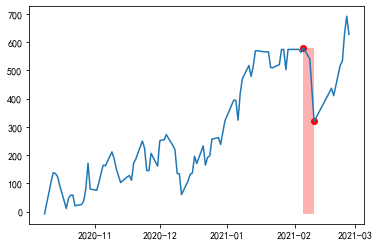

In [17]:
from wmpy.trader.utility import performance_summary
performance_summary(df, key='net_pnl', _plot=True, _print=True)

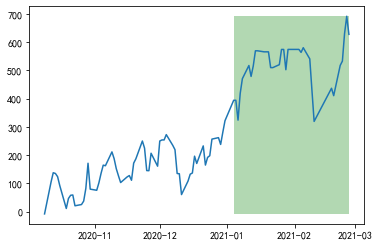

In [18]:
# 20210101后为样本外数据
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 1, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)